# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2021-s109a/blob/master/lectures/crest.png?raw=true"> CS-S109A Introduction to Data Science 

## Homework 5: Trees, Forests, and Boosting

**Harvard University**<br/>
**Summer 2021**<br/>
**Instructors**: Kevin Rader


<hr style='height:2px'>

---



In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

<hr style="height:2pt">

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces only other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training observations, {len(data_test)} test observations")
print(data_train.shape[1],"total columns")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training observations, 5000 test observations
29 total columns

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.884,-0.462,0.196,1.330,1.520,1.040,-1.5200,-1.46,2.17,0.361,-2.030,-0.253,0.00,0.337,-0.597,-0.324,2.55,0.493,1.030,-1.1400,0.0,1.450,0.791,1.400,1.250,0.713,0.812,0.821,1.0
1,0.780,-0.292,0.897,0.384,0.413,1.220,-0.4660,-0.92,0.00,1.100,-1.200,1.080,2.21,0.498,1.490,1.060,0.00,0.493,-0.344,-0.0918,0.0,0.812,0.728,0.975,0.637,0.569,0.777,0.715,1.0
2,0.353,-1.070,-1.740,1.170,-0.199,0.558,0.0574,-1.49,1.09,0.912,-1.080,0.571,0.00,0.781,-0.320,-1.040,2.55,0.616,-1.510,1.5500,0.0,0.829,1.060,0.992,0.825,0.365,0.800,0.766,0.0
3,0.757,0.822,-1.290,0.208,-0.151,1.220,-1.6400,1.53,0.00,1.680,0.189,-0.645,0.00,1.780,0.285,0.520,2.55,1.130,-0.932,0.1170,3.1,4.290,2.420,0.995,0.923,0.927,1.760,1.360,1.0
4,2.040,2.030,-0.472,0.424,-1.500,1.060,0.7980,1.22,2.17,0.805,-0.661,-1.460,0.00,0.885,1.440,0.809,0.00,1.290,0.493,-0.0791,3.1,0.895,0.936,1.030,1.560,1.150,1.120,1.160,1.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.986168,0.011449,-0.011057,0.995656,-0.026783,0.990357,0.006779,0.008310,0.999370,0.992922,0.015321,0.010629,1.014648,0.984070,0.017681,-0.012232,0.992122,0.982671,-0.020045,0.017153,0.996650,1.024146,1.023271,1.047602,1.005986,0.972397,1.027461,0.954268,0.529600
std,0.550671,1.015018,1.012867,0.601449,1.012443,0.483224,1.005735,0.992744,1.023674,0.499675,0.994269,1.007182,1.046952,0.478845,1.012092,1.007317,1.198333,0.505908,1.005818,1.020375,1.395097,0.596476,0.352384,0.155067,0.402897,0.515233,0.360030,0.314996,0.499173
min,0.275000,-2.390000,-1.740000,0.014000,-1.740000,0.236000,-2.960000,-1.740000,0.000000,0.190000,-2.870000,-1.740000,0.000000,0.265000,-2.730000,-1.740000,0.000000,0.366000,-2.490000,-1.740000,0.000000,0.161000,0.310000,0.493000,0.445000,0.048100,0.417000,0.448000,0.000000
25%,0.584000,-0.729000,-0.891250,0.569000,-0.901000,0.676000,-0.688250,-0.840000,0.000000,0.661000,-0.688250,-0.859250,0.000000,0.651000,-0.686250,-0.873250,0.000000,0.616000,-0.728000,-0.884500,0.000000,0.791750,0.849000,0.986000,0.766750,0.675000,0.819000,0.767000,0.000000
50%,0.855000,0.013600,-0.023250,0.890000,-0.031950,0.888000,0.012800,0.030100,1.090000,0.890000,0.014150,0.019600,1.110000,0.887000,0.003810,-0.007130,0.000000,0.871000,-0.033800,0.024800,0.000000,0.892000,0.957000,0.990000,0.910000,0.875000,0.941000,0.865000,1.000000
75%,1.230000,0.771000,0.860250,1.290000,0.854000,1.170000,0.702000,0.850250,2.170000,1.210000,0.691250,0.871250,2.210000,1.210000,0.717000,0.863000,2.550000,1.220000,0.714250,0.917250,3.100000,1.030000,1.090000,1.020000,1.130000,1.140000,1.130000,1.050000,1.000000
max,4.960000,2.400000,1.740000,5.510000,1.740000,5.320000,2.960000,1.740000,2.170000,4.930000,2.900000,1.740000,2.210000,5.410000,2.710000,1.740000,2.550000,7.510000,2.500000,1.740000,3.100000,9.280000,5.180000,3.930000,4.800000,5.560000,4.690000,5.990000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

---

<div class='exercise'><b>Question 1 [25 pts]: Base Modeling </b></div>
We begin by looking at parametric approaches to modeling the Boson data.

**1.1** Calculate the correlation matrix (using `df.corr()` from pandas) between all predictors in the training data set and represent this as a heatmap using (`seaborn.heatmap`).  What does the suggest about the presence of muilticollinearity in the predictor set?

**1.2** Fit a logistic regression model to predict `class` from all 28 of the predictors, and evaluate the model's accuracy on both the training and test sets.

**1.3** Fit a logistic regression model to predict `class` from all 28 of the predictors and all two-way interactions between these predictors (you should have $28+{28 \choose 2} = 406$ columns in the design matrix, ignoring the intercept).  Evaluate the model's accuracy on both the training and test sets.

Hint: you may have to scale your predictors (purely for numerical reasons) and use`maxiter=2000` to avoid the warnings (the next part as well).

**1.4** Use 'L2' regularization on the model in the previous part, tuning the penalty term using 5-fold cross-validation (consider the set of Cs to be [0.01,0.1,1,10,100,1000]).  Which penalty term performed best?  Evaluate the best model's accuracy on both the training and test sets and assign them to variables named `logistic_train_score` and `logistic_test_score`.

**1.5** Compare the performance of the 3 models above.  Which model performs the best on the train set?  Which the best on the test set?  Is this expected?

## Answers:

**1.1** Calculate the correlation matrix (using `df.corr()` from pandas) between all predictors in the training data set and represent this as a heatmap using (`seaborn.heatmap`).  What does the suggest about the presence of muilticollinearity in the predictor set?

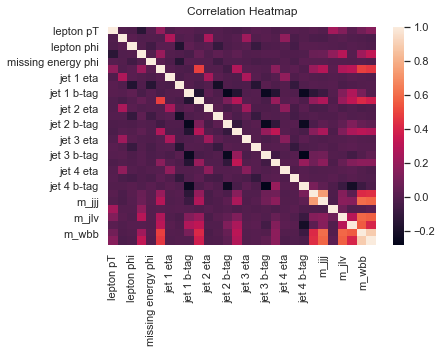

In [6]:
columns = list(data_train.columns)
columns.remove('class')
heatmap = sns.heatmap(pd.DataFrame(X_train, columns=columns).corr());
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

We can see here a low amount of correlation between variables over the dataset which suggests that there exists a slight degree of multicollinearity in the predictor sets. More notably, `m_wbb` and `m_wwbb` seem to have a higher degree of correlation than the others.	

**1.2** Fit a logistic regression model to predict `class` from all 28 of the predictors, and evaluate the model's accuracy on both the training and test sets.

In [7]:
log_model = LogisticRegression(fit_intercept=True, penalty="none").fit(X_train, y_train)

train_accuracy = log_model.score(X_train, y_train)
test_accuracy = log_model.score(X_test, y_test)

print("Training Accuracy for logistic regression: {}".format(train_accuracy))
print("Test Accuracy for logistic regression:     {}".format(test_accuracy))

Training Accuracy for logistic regression: 0.6546
Test Accuracy for logistic regression:     0.6288


**1.3** Fit a logistic regression model to predict `class` from all 28 of the predictors and all two-way interactions between these predictors (you should have $28+{28 \choose 2} = 406$ columns in the design matrix, ignoring the intercept).  Evaluate the model's accuracy on both the training and test sets.

Hint: you may have to scale your predictors (purely for numerical reasons) and use`maxiter=2000` to avoid the warnings (the next part as well).

In [8]:
from sklearn.preprocessing import StandardScaler

# scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# add interaction terms
interaction_terms = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_scaled_with_interactions = interaction_terms.fit_transform(X_train_scaled)
X_test_scaled_with_interactions = interaction_terms.fit_transform(X_test_scaled)

log_interact_model = LogisticRegression(max_iter=2000,
                                        fit_intercept=True, 
                                        penalty="none").fit(X_train_scaled_with_interactions, y_train)

# get the accuracy
train_scaled_accuracy = log_interact_model.score(X_train_scaled_with_interactions, y_train)
test_scaled_accuracy = log_interact_model.score(X_test_scaled_with_interactions, y_test)

print("Training Accuracy for logistic regression w interactions: {}".format(train_scaled_accuracy))
print("Test Accuracy for logistic regression w interactions:     {}".format(test_scaled_accuracy))

Training Accuracy for logistic regression w interactions: 0.7094
Test Accuracy for logistic regression w interactions:     0.6312


**1.4** Use 'L2' regularization on the model in the previous part, tuning the penalty term using 5-fold cross-validation (consider the set of Cs to be [0.01,0.1,1,10,100,1000]).  Which penalty term performed best?  Evaluate the best model's accuracy on both the training and test sets. 



In [9]:
from sklearn.linear_model import LogisticRegressionCV

Cs = [0.01,0.1,1,10,100,1000]
cross_scores = []

for C in Cs:
    lr_model2 = LogisticRegression(max_iter=2000, penalty='l2', C = C)
    val_score = cross_val_score(lr_model2, X_train_scaled_with_interactions, y_train, cv=5).mean()
    cross_scores.append(val_score)

index = np.argmax(cross_scores)

print("The best C is {}".format(Cs[index]))

reg_log_interact_model = LogisticRegression(max_iter=2000, 
                                            penalty='l2', 
                                            C = Cs[index]).fit(X_train_scaled_with_interactions, y_train)

# get the accuracy
train_reg_log_accuracy = reg_log_interact_model.score(X_train_scaled_with_interactions, y_train)
test_reg_log_accuracy = reg_log_interact_model.score(X_test_scaled_with_interactions, y_test)

print("Training Accuracy for regularized logistic regression: {}".format(train_reg_log_accuracy))
print("Test Accuracy for regularized logistic regression:     {}".format(test_reg_log_accuracy))

The best C is 1
Training Accuracy for regularized logistic regression: 0.7098
Test Accuracy for regularized logistic regression:     0.6306


**1.5** Compare the performance of the 3 models above.  Which model performs the best on the train set?  Which the best on the test set?  Is this expected?

The model that performs the best on the train set is the 'L2' regularized scaled Logistic Regression, while the one that performs the best on the test set is the unregularized scaled Logistic Regression model. This is not expected, as we would expect a regularized model to temper the coefficients so as to not overfit on the training set with a lower train score but a higher test score.

---

<div class='exercise'><b>Question 2 [30 pts]: Tree and Forest Models </b></div>
Our first go to tree-based models, along with our first ensemble methods (bagging and random forests) which we played around with a bit on homework 4.

**2.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance. 
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`  

*Hint*: use `plt.fill_between` to shade the region.

**2.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.

**2.3** Fit a Bagging model using the `X_train` data.  Tune (1) the tree depth from the depths of [5.10.15], and (2) the number of trees from the options [20,50,100].  Evaluate its accuracy on the train and test sets and assign it to variables named `bagging_train_score` and `bagging_test_score`.

**2.4** Fit a `RandomForestClassifier` using the original `X_train` data using the same tree depth and number of trees that you used in the previous question, but tune the number features to consider when looking for the best splits (consider from the list [5,10,15,20,25]). Evaluate its accuracy on the train and test sets and assign it to variables named `random_forest_train_score` and `random_forest_test_score`.

**2.5** Why should the bagging model be tuned to a `max_depth` that is at least as deep as the best single tree depth (from 2.2)?

**2.6**: If you were to run your code again for the bagging and random forest models, would you get the same results?  Why?


## Answers

**2.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance. 
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`  

*Hint*: use `plt.fill_between` to shade the region.


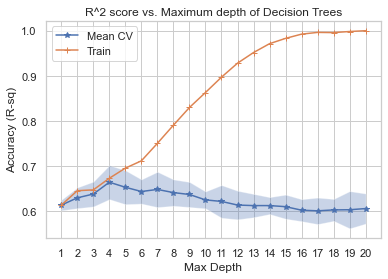

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

depths = list(range(1, 21))
trainscores = []
cvmeans = []
cvstds = []

for depth in depths:
    dtree = DecisionTreeClassifier(max_depth=depth)
    
    # Perform 5-fold cross validation and store results
    trainscores.append(dtree.fit(X_train, y_train).score(X_train, y_train))
    scores = cross_val_score(estimator=dtree, X=X_train, y=y_train, cv=5)
    cvmeans.append(scores.mean())
    cvstds.append(scores.std())

cvmeans = np.array(cvmeans)
cvstds = np.array(cvstds)

# plotting
plt.plot(depths, cvmeans, '*-', label="Mean CV")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, alpha=0.3)
ylim = plt.ylim()
plt.plot(depths, trainscores, '-+', label="Train")
plt.legend()
plt.ylabel("Accuracy (R-sq)")
plt.xlabel("Max Depth")
plt.title("R^2 score vs. Maximum depth of Decision Trees")
plt.xticks(depths);


**2.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.

In [11]:
'''From the plot in the previous question, it is clear that 
the `max_depth` of 4 yeilds the highest mean CV score so we 
shall use as the depth for the model'''

best_dtree = DecisionTreeClassifier(max_depth=4)
best_dtree.fit(X_train, y_train)

best_cv_tree_train_score = best_dtree.score(X_train, y_train)
best_cv_tree_test_score = best_dtree.score(X_test, y_test)

print("Training accuracy of simple decision tree:", best_cv_tree_train_score)
print("Test accuracy of simple decision tree:    ", best_cv_tree_test_score)

Training accuracy of simple decision tree: 0.6728
Test accuracy of simple decision tree:     0.6354


**2.3** Fit a Bagging model using the `X_train` data.  Tune (1) the tree depth from the depths of [5.10.15], and (2) the number of trees from the options [20,50,100].  Evaluate its accuracy on the train and test sets and assign it to variables named `bagging_train_score` and `bagging_test_score`.

In [12]:
depths = [5,10,15]
ntrees_list = [20,50,100]

scores_list = []

for count, depth in enumerate(depths):
    scores_list.append([])
    
    for ntrees in ntrees_list:
    
        rf = RandomForestClassifier(n_estimators=ntrees, max_depth=depth, max_features=None, random_state=109)
        score = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=5).mean()
        
        scores_list[count].append(score)

scores_list


[[0.6726, 0.6772, 0.6774000000000001],
 [0.6788000000000001, 0.681, 0.6898000000000001],
 [0.6724, 0.6804, 0.688]]

In [13]:
arr = np.array(scores_list)
optimal_depth = depths[np.unravel_index(arr.argmax(), arr.shape)[0]]
optimal_ntrees = ntrees_list[np.unravel_index(arr.argmax(), arr.shape)[1]]
print("Depth:", optimal_depth)
print("ntrees:", optimal_ntrees)

Depth: 10
ntrees: 100


In [14]:
'''From inspection, we can see the model with the highest
CV accuracy is a tree with depth 10 and 100 trees.'''
best_bagging_model = RandomForestClassifier(n_estimators=optimal_ntrees, 
                                            max_depth=optimal_depth, 
                                            max_features=None, 
                                            random_state=109)
best_bagging_model.fit(X_train, y_train)

bagging_train_score = best_bagging_model.score(X_train, y_train)
bagging_test_score = best_bagging_model.score(X_test, y_test)

print("Training accuracy for bagging model:", bagging_train_score)
print("Test accuracy for bagging model:    ", bagging_test_score)


Training accuracy for bagging model: 0.9432
Test accuracy for bagging model:     0.6824


**2.4** Fit a `RandomForestClassifier` using the original `X_train` data using the same tree depth and number of trees that you used in the previous question, but tune the number features to consider when looking for the best splits (consider from the list [5,10,15,20,25]). Evaluate its accuracy on the train and test sets and assign it to variables named `random_forest_train_score` and `random_forest_test_score`.




In [15]:
features = [5,10,15,20,25]
scores_list = []
    
for n in features:
    rf = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=n)
    score = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=5).mean()
    
    scores_list.append(score)
    
print("Number of features with highest accuracy:", features[np.argmax(scores_list)])

Number of features with highest accuracy: 10


In [16]:
best_rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=features[np.argmax(scores_list)])
best_rf_model.fit(X_train, y_train)

random_forest_train_score = best_rf_model.score(X_train, y_train)
random_forest_test_score = best_rf_model.score(X_test, y_test)

print("Training accuracy for RF:", random_forest_train_score)
print("Test accuracy for RF:    ", random_forest_test_score)

Training accuracy for RF: 0.9354
Test accuracy for RF:     0.6842


**2.5** Why should the bagging model be tuned to a `max_depth` that is at least as deep as the best single tree depth (from 2.2)?



This is because we want the base trees in bagging to be more complicated than a single tree. With lower bias and high variance in the base trees, we can reach lower bias and lower variance than a single decision tree with our bagging approach. 
If the trees in the bagging model are less than the `max_depth` of the single tree, we would end up having trees with high bias which then would lead us to have high bias even in the final bagged model. 

**2.6**: If you were to run your code again for the bagging and random forest models, would you get the same results?  Why?


If we didn't set `random_state=109`, we would get similar results but not the same as there is a certain randomness associated with both methods. Bootstrap in bagging almost ensures that the data seen is slightly different each time based on probability, whereas RF builds on that (with even randomness in the features selected each time).

In our case we did set `random_state` to $109$ so we would get the same results if we ran the code again.

---

<div class='exercise'><b> Question 3 [30 pts]: Boosting </div>
In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**3.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

**3.2** Use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree with `max_depth=3` as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**3.3** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**3.4** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

**3.5** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**3.6** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

## Answers

**3.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

The train score for `tree1` is 0.647
The test score for `tree1` is 0.6392


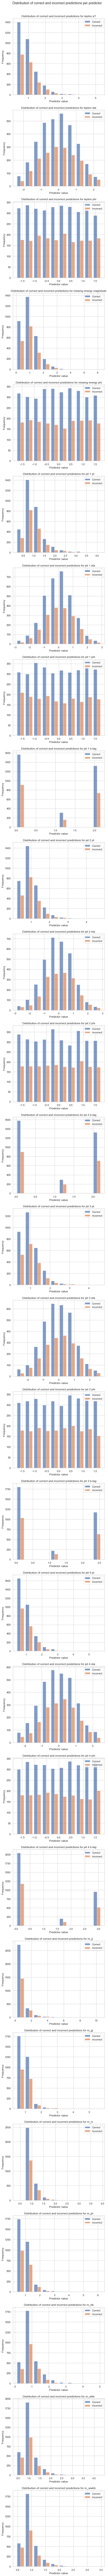

In [18]:
tree1 = DecisionTreeClassifier(max_depth=3).fit(X_train,y_train)
train_score = tree1.score(X_train, y_train)
test_score = tree1.score(X_test, y_test)
print("The train score for `tree1` is {}".format(train_score))
print("The test score for `tree1` is {}".format(test_score))


# PLOTS
fig, axes = plt.subplots(X_train.shape[1], 1, figsize=(7, 200))
fig.suptitle("Distribution of correct and incorrect predictions per predictor", y=0.885)

y_pred = tree1.predict(X_test)

for i in range(len(columns)):
    success = []
    failure = []
    
    for j in range(len(y_pred)):
        if y_pred[j] == y_test[j]:
            success.append(X_test[j, i])
        else:
            failure.append(X_test[j, i])
    
        bins=np.histogram(np.hstack((success, failure)), bins=10)[1]
    
    axes[i].hist([success, failure], alpha = 0.7, bins=bins, label=["Correct", "Incorrect"])
    axes[i].legend(loc="upper right")
    
    axes[i].set_title("Distribution of correct and incorrect predictions for " + columns[i])
    axes[i].set_xlabel('Predictor value')
    axes[i].set_ylabel('Frequency')


The train score for `tree1` is 0.647 <br>
The test score for `tree1` is 0.6392 <br>
All the predictors have very similar distributions except for `missing energy phi`, `jet 1 phi`, `jet 2 phi`, `jet 4 phi` which had a slightly different distributions for correct and incorrect classifications. It seems like when there is a fairly uniform distribution of classifications across all values of a predictor, there is a difference in distribution. 

**3.2** Use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree with `max_depth=3` as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.



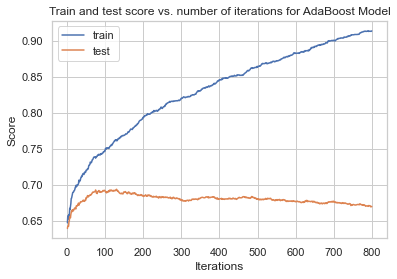

In [19]:
base = DecisionTreeClassifier(max_depth=3)
boost = AdaBoostClassifier(base_estimator=base, n_estimators=800, learning_rate=0.05, random_state=109)
boost.fit(X_train, y_train)

train_s = list(boost.staged_score(X_train, y_train))
test_s = list(boost.staged_score(X_test, y_test))

dummy = np.arange(1, 801)

plt.plot(dummy, train_s, label="train")
plt.plot(dummy, test_s, label="test")
plt.xlabel("Iterations")
plt.ylabel("Score")
plt.title("Train and test score vs. number of iterations for AdaBoost Model")
plt.legend()
plt.show()

**3.3** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)



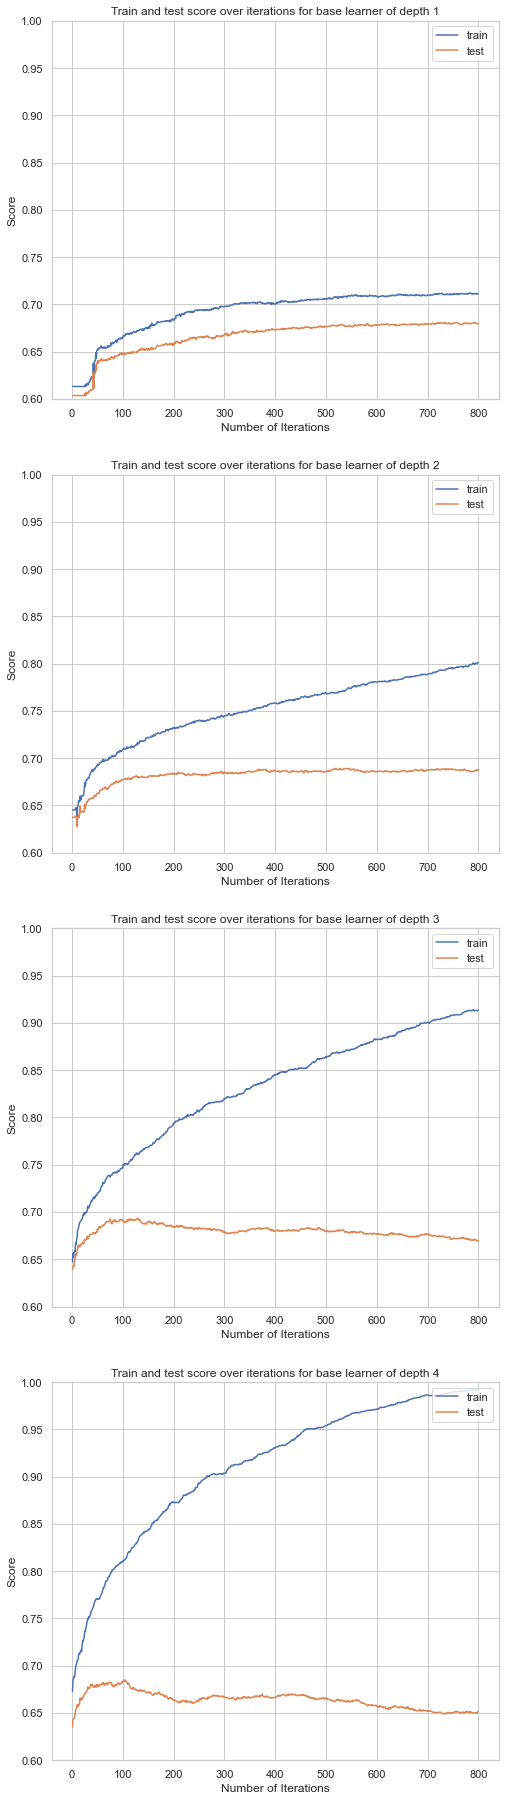

In [20]:
fig, axes = plt.subplots(4, 1, figsize=(8, 32))

for i in range(4):
    base = DecisionTreeClassifier(max_depth=i+1)
    boost = AdaBoostClassifier(base_estimator=base, n_estimators=800, learning_rate=0.05, random_state=109)
    boost.fit(X_train, y_train)

    train_s = list(boost.staged_score(X_train, y_train))
    test_s = list(boost.staged_score(X_test, y_test))

    dummy = np.arange(1, 801)
    axes[i].set_ylim((0.6,1.0))

    axes[i].plot(dummy, train_s, label="train")
    axes[i].plot(dummy, test_s, label="test")
    axes[i].legend(loc="upper right")
    
    axes[i].set_title("Train and test score over iterations for base learner of depth {}".format(str(i + 1)))
    axes[i].set_xlabel('Number of Iterations')
    axes[i].set_ylabel('Score')

We see that the decline in improvements in test score occurs most rapidly in AdaBoost models with more complex decision trees. Despite all 4 models reaching a peak test score of around 0.68, adaboost with base tree of depth 3 or 4 declines after a few hundred iterations (the other models with depth 1 and 2 simply plateau after a certain point). Meanwhile, the peak train scores show an upward trend in all the graphs but its absolute value increases with more complex base models.



**3.4** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?



In [21]:
'''Eyeballing the graphs it seems like a max_depth of 3
combined with 100 iterations provides the best performance.
We come to this conclusion by observing which graph has the
highest test set accuracy.'''

base = DecisionTreeClassifier(max_depth=3)
boost = AdaBoostClassifier(base_estimator=base, n_estimators=100, learning_rate=0.05)
boost.fit(X_train, y_train)
train_s = list(boost.staged_score(X_train, y_train))
test_s = list(boost.staged_score(X_test, y_test))

print("Training Accuracy for AdaBoost:", train_s[np.argmax(test_s)])
print("Test Accuracy for AdaBoost:    ",np.max(test_s))

Training Accuracy for AdaBoost: 0.7368
Test Accuracy for AdaBoost:     0.6926


Optimal base learner depth appears to be base learner of depth 3 after around 100 iterations, because it reaches the highest test score of all four models as per the graphs. This is better than random forest and bagging which resulted in test scores of 0.64 and 0.63 respectively.


**3.5** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

The first disadvantage of having too many trees is the high computational cost. In the case of bagging, multiple processors could be used but too many trees still need a lot of computation power. With the iterative boosting, the computational cost on a single computer is even higher.

The other problem with regards to bagging is that the model starts to become more biased to the training data. For each tree, we resample from the same `X_train` and repetitively doing many times that will result in many trees being very similar. This would lead to overfitting to the training data thus reducing accuracy. This boils down to the variance-bias tradeoff: we reduce the vairance with each extra tree added but increase the bias.
The problem with overfitting lies with boosting too as we fit the model to the residuals to a very high degree.

**3.6** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

Bagging is better suited to parallelization, because you can create many random trees using different computers (as they don't build off each other), whereas boosting requires iteratively improving on the same estimator by fitting on its residuals, so it cannot take advantage of parallelization.

---

<div class='exercise'> <b> Question 4 [15 pts]: Model Comparison </b> </div>


**4.1**: Make a pandas table of the training and test accuracy for the following 5 models and name it `results_df`:

- The tuned L2-regularized logistic regression (from Question 1)
- Single tree with best depth chosen by cross-validation (from Question 2)
- Your tuned bagging model (from Question 2)
- Your tuned random forest model  (from Question 2)
- Your tuned adaBoost model  (from Question 3)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.


**4.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?


**4.3** Which of these techniques can be extended to regression tasks? How?

## Answers

**4.1**: Make a pandas table of the training and test accuracy for the following 6 models and name it `results_df`:

- The full logistic regression (from Question 1.3)
- The tuned L2-regularized logistic regression (from Question 1.4)
- Single tree with best depth chosen by cross-validation (from Question 2)
- Your tuned bagging model (from Question 2)
- Your tuned random forest model  (from Question 2)
- Your tuned adaBoost model  (from Question 3)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

---

Fill in the following table.


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| logistic  | | |
| regularized logistic  | | |
| single tree  | | |
| bagging | | |
| random forest  | | |
| adaboost  | | |

In [22]:
'''
- The full logistic regression (from Question 1.3)
- The tuned L2-regularized logistic regression (from Question 1.4)
- Single tree with best depth chosen by cross-validation (from Question 2)
- Your tuned bagging model (from Question 2)
- Your tuned random forest model  (from Question 2)
- Your tuned adaBoost model  (from Question 3)
'''
classifier = ['logistic', "regularized", "single tree", "bagging", "random forest", "adaboost"]
train_acc = [train_scaled_accuracy, train_reg_log_accuracy, best_cv_tree_train_score, bagging_train_score, random_forest_train_score, train_s[np.argmax(test_s)]]
test_acc = [test_scaled_accuracy, test_reg_log_accuracy, best_cv_tree_test_score, bagging_test_score, random_forest_test_score, np.max(test_s)]

data = {
    "classifier": classifier,
    "train accuracy": train_acc,
    "test accuracy": test_acc
}
results_df = pd.DataFrame(data)
results_df

,classifier,train accuracy,test accuracy
0,logistic,0.7094,0.6312
1,regularized,0.7098,0.6306
2,single tree,0.6728,0.6354
3,bagging,0.9432,0.6824
4,random forest,0.9354,0.6842
5,adaboost,0.7368,0.6926


**Training Accuracy:** 
Bagging has the highest accuracy with 0.943, followed closely by random forest at 0.935. These two models separate themselves from the crowd with the next highest being adaboost at 0.737. Logistic and regualrized logistic regression are at the bottom with nearly the same accuracy of $\approx$ 0.709.

**Test Accuracy:**
Adaboost is the most accurate on the test set (0.6926). Bagging and Random Forest have similar accuracies (both around 0.68 but RF has a slight edge). The non-ensemble methods are far less accurate with the single tree model being the most accurate among the lot, followed by logistic regression and regularized logistic regression.

For the ensemble methods like bagging and random forests which are focused on reducing variance by using many trees, we see that they accomplish that task pretty well on the training set with the highest accuracies. But they are subject to liking the training set too much (too biased to the training data, aka overfitting) which leads to a lower test accuracy. 

The surprise was the case of the regularized and the normal logistic regression: we expect the regularized model to be performing better on the test set but that was not the case. 

**4.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?



The bagging model worked best on the training set with the highest training accuracy. But if it comes to the best model which works on the test set, it is the AdaBoost model with its base model being a simple decision tree. 

The way AdaBoost works is that it fits the model on the residuals which offers a unique way of modellling different from the other methods. This new approach might have exploited a certain aspect of the data which resulted in higher test accuracy results.


**4.3** Which of these techniques can be extended to regression tasks? How?


It is not possible to extend the logistic regression (regularized and un-regularized) model to solve regression tasks. 
This would involve transforming the non-linear logistic regression to a linear model which is not possible.
\
\
The single tree model can easily be extended to regression tasks by doing the following two steps: (1) select a splitting criterion that promotes splits that improves the predictive accuracy of the model as measured by, say, overall MSE and (2) we need to label each region with a real number - typically the average of the output values of the training pointscontained in the region. 
\
\
Bagging is a natural extension to a single tree model where we can just average the predictions from each of the trees to get the overall prediction of the model. It is very similar for Random Forests where only the way splits are done is a little different.
\
\
AdaBoost enhances the base models by working on the residuals and trying to reduce them. This essentially menas that with the AdaBoost procedure, we could solve regression tasks too.